In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import PIL
from PIL import Image
import matplotlib
from matplotlib import pyplot as plt
import os

In [3]:
hi_res_images = np.load("/kaggle/input/super-resolution-2/hi_res_images.npy")
low_res_images = np.load("/kaggle/input/super-resolution-2/low_res_images.npy")

In [4]:
print(hi_res_images.shape)
print(low_res_images.shape)

(1254, 400, 400, 3)
(1254, 100, 100, 3)


In [5]:
lr_input = keras.layers.Input(shape=(100, 100, 3))
hr_input = keras.layers.Input(shape=(400, 400, 3))

lr_train = low_res_images[:900]
hr_train = hi_res_images[:900]

lr_test = low_res_images[900:]
hr_test = hi_res_images[900:]

In [6]:
class PixelShuffler(tf.keras.layers.Layer):
    def __init__(self, scale, **kwargs):
        super(PixelShuffler, self).__init__(**kwargs)
        self.scale = scale

    def call(self, inputs):
        return self.depth_to_space(inputs, self.scale)

    def compute_output_shape(self, input_shape):
        batch_size, height, width, channels = input_shape
        new_height = height * self.scale if height is not None else None
        new_width = width * self.scale if width is not None else None
        new_channels = channels // (self.scale ** 2) if channels is not None else None
        return (batch_size, new_height, new_width, new_channels)

    def depth_to_space(self, inputs, scale):
        x = tf.nn.depth_to_space(inputs, scale)
        return x

'''
def create_generator(inp):
    layers = keras.layers.Conv2D(64, (9, 9), padding='same')(inp)
    layers = keras.layers.PReLU(shared_axes=[1, 2])(layers)
    
    temp = layers
    
    res_model = keras.layers.Conv2D(64, (3, 3), padding='same')(layers)
    res_model = keras.layers.BatchNormalization(momentum=0.5)(res_model)
    res_model = keras.layers.PReLU(shared_axes=[1, 2])(res_model)
    
    res_model = keras.layers.Conv2D(64, (3, 3), padding='same')(res_model)
    res_model = keras.layers.BatchNormalization(momentum=0.5)(res_model)
        
    res_model = keras.layers.Conv2D(64, (3,3), padding='same')(res_model)
    res_model = keras.layers.BatchNormalization(momentum=0.5)(res_model)
    
    res_model = keras.layers.add([res_model, temp])

    up_model = keras.layers.Conv2D(256, (3, 3), padding='same')(res_model)
    up_model = PixelShuffler(scale=2)(up_model)
    up_model = keras.layers.PReLU(shared_axes=[1, 2])(up_model)

    up_model = keras.layers.Conv2D(256, (3, 3), padding='same')(up_model)
    up_model = PixelShuffler(scale=2)(up_model)
    up_model = keras.layers.PReLU(shared_axes=[1, 2])(up_model)
    

    out = keras.layers.Conv2D(3, (9,9), padding='same')(up_model)
    
    return keras.Model(inputs=inp, outputs=out)
'''

# Residual block
def res_block(ip):
    
    res_model = keras.layers.Conv2D(64, (3,3), padding = "same")(ip)
    res_model = keras.layers.BatchNormalization(momentum = 0.5)(res_model)
    res_model = keras.layers.PReLU(shared_axes = [1,2])(res_model)
    
    res_model = keras.layers.Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = keras.layers.BatchNormalization(momentum = 0.5)(res_model)
    
    return keras.layers.add([ip,res_model])
# Upscale the image 2x
def upscale_block(ip):
    
    up_model = keras.layers.Conv2D(256, (3,3), padding="same")(ip)
    up_model = PixelShuffler(scale = 2)(up_model)
    up_model = keras.layers.PReLU(shared_axes=[1,2])(up_model)
    
    return up_model
num_res_block = 16
# Generator Model
def create_generator(gen_ip):
    layers = keras.layers.Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = keras.layers.PReLU(shared_axes=[1,2])(layers)
    temp = layers
    for i in range(num_res_block):
        layers = res_block(layers)
    layers = keras.layers.Conv2D(64, (3,3), padding="same")(layers)
    layers = keras.layers.BatchNormalization(momentum=0.5)(layers)
    layers = keras.layers.add([layers,temp])
    layers = upscale_block(layers)
    layers = upscale_block(layers)
    op = keras.layers.Conv2D(3, (9,9), padding="same")(layers)
    return keras.Model(inputs=gen_ip, outputs=op)

In [8]:
generator = create_generator(lr_input)

generator.compile(loss=["mse"], optimizer="adam", metrics=['accuracy'])
generator.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 100, 100,  │     15,616 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_19 (PReLU)  │ (None, 100, 100,  │         64 │ conv2d_37[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 100, 100,  │     36,928 │ p_re_lu_19[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 100,  │        256 │ conv2d_38[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_20 (PReLU)  │ (None, 100, 100,  │         64 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 100, 100,  │     36,928 │ p_re_lu_20[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 100,  │        256 │ conv2d_39[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, 100, 100,  │          0 │ p_re_lu_19[0][0], │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 100, 100,  │     36,928 │ add_17[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 100,  │        256 │ conv2d_40[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_21 (PReLU)  │ (None, 100, 100,  │         64 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 100, 100,  │     36,928 │ p_re_lu_21[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 100,  │        256 │ conv2d_41[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_18 (Add)        │ (None, 100, 100,  │          0 │ add_17[0][0],     │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 100, 100,  │     36,928 │ add_18[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 100,  │        256 │ conv2d_42[0][0] 

 Total params: 1,554,883 (5.93 MB)

 Trainable params: 1,550,659 (5.92 MB)

 Non-trainable params: 4,224 (16.50 KB)

In [9]:
history = generator.fit(lr_train, hr_train, epochs=70)

Epoch 1/70


2024-03-04 17:59:04.583830: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng20{k2=1,k4=3,k5=1,k6=0,k7=0} for conv (f32[32,3,400,400]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,400,400]{3,2,1,0}, f32[3,64,9,9]{3,2,1,0}, f32[3]{0}), window={size=9x9 pad=4_4x4_4}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-03-04 17:59:04.831008: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.247355152s
Trying algorithm eng20{k2=1,k4=3,k5=1,k6=0,k7=0} for conv (f32[32,3,400,400]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,400,400]{3,2,1,0}, f32[3,64,9,9]{3,2,1,0}, f32[3]{0}), window={size=9x9 pad=4_4x4_4}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0

29/29 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.3380 - loss: 0.1421
Epoch 2/70
29/29 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.5085 - loss: 0.0197
Epoch 3/70
29/29 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.6107 - loss: 0.0123
Epoch 4/70
29/29 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.5837 - loss: 0.0145
Epoch 5/70
29/29 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.6202 - loss: 0.0094
Epoch 6/70
29/29 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.6359 - loss: 0.0079
Epoch 7/70
29/29 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.6298 - loss: 0.0078
Epoch 8/70
29/29 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.6363 - loss: 0.0073
Epoch 9/70
29/29 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.6665 - loss: 0.0062
Epoch 10/70
29/29 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.6989 - loss: 0.0058
Epoch 11/70
29/29 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.7134 - loss: 0.0055
Epoch 12/70
29/29 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.7129 - loss: 0.0054

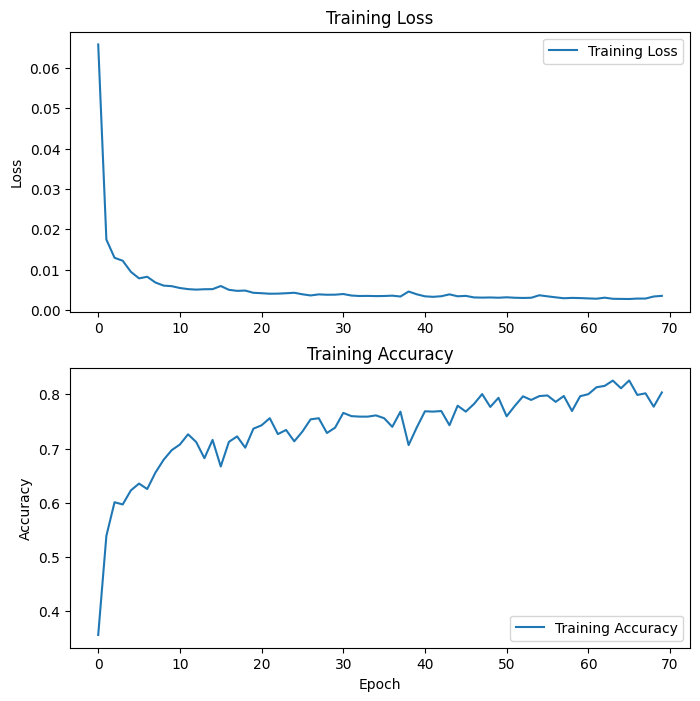

In [10]:
# Plot the training and validation loss and accuracy
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

axs[0].plot(history.history['loss'], label='Training Loss')
axs[0].legend(loc='upper right')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss')

axs[1].plot(history.history['accuracy'], label='Training Accuracy')
axs[1].legend(loc='lower right')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Training Accuracy')

plt.xlabel('Epoch')
plt.show()

In [12]:
generator.save_weights('model_weights.weights.h5')

In [13]:
results = generator.evaluate(lr_test, hr_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 719ms/step - accuracy: 0.8114 - loss: 0.0033


In [14]:
print(results)

[0.0037261315155774355, 0.8021169304847717]
